In [ ]:
!pip install keras_unet_collection
from keras_unet_collection import models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
import glob
import cv2
import os
import keras_unet_collection.losses as loss
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from skimage import filters

In [ ]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/niharika/suadd23")

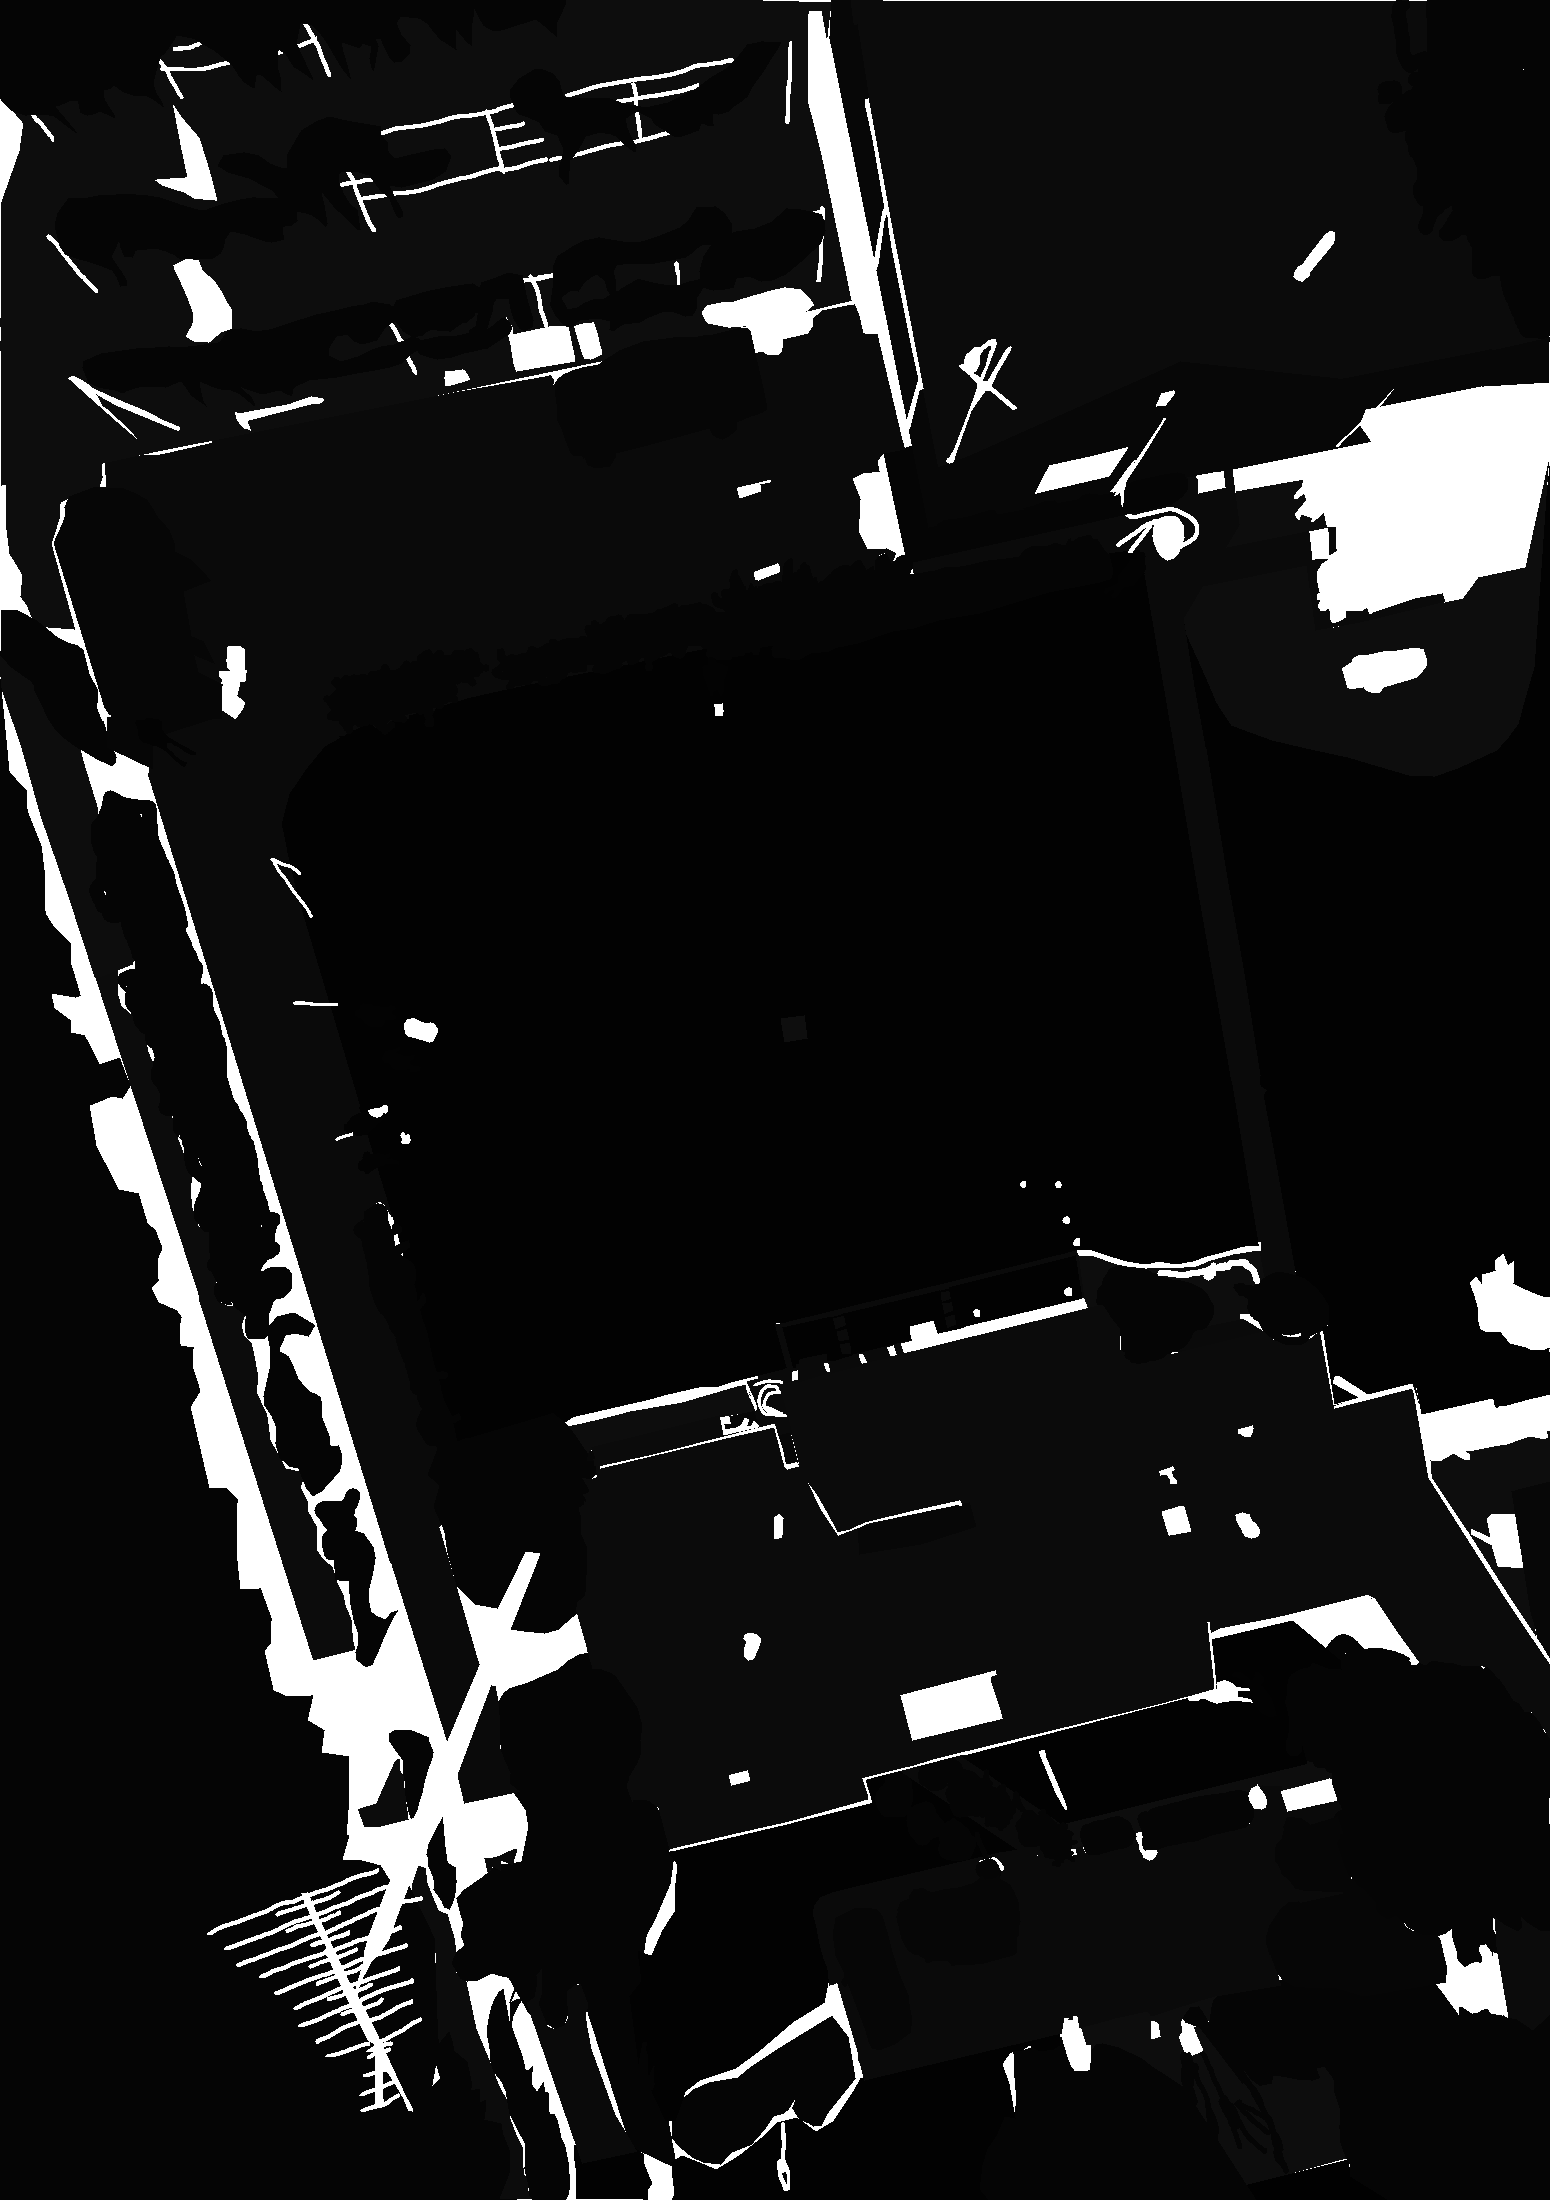

(2200, 1550, 3)
[  1   2   3   5   6   7  10  11  12  13  14 255]


In [ ]:
from google.colab.patches import cv2_imshow
im = cv2.imread("/content/suadd23/semantic_annotations/019c9f9128464ab59a58f2e95f83d55a-1631898858600005621.png")
cv2_imshow(im)
print(im.shape)
print(np.unique(im))

In [ ]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256
MASK_SIZE = 64


#Capture training image info as a list
def load_images(a, b):
  train_image_names = glob.glob("/content/suadd23/inputs/*.png")
  train_mask_names = glob.glob("/content/suadd23/semantic_annotations/*.png")

  train_image_names.sort()
  train_mask_names.sort()

  train_images = [cv2.resize(cv2.imread(img, 0), (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST) for img in train_image_names[a:b]]
  train_masks = [cv2.resize(cv2.imread(msk, 0), (MASK_SIZE, MASK_SIZE), interpolation=cv2.INTER_NEAREST)  for msk in train_mask_names[a:b]]

  print(np.unique(train_masks[0]))

  train_images = np.array(train_images)

  train_masks = np.array(train_masks)

  return train_images, train_masks

In [ ]:
#RUN TILL HERE FOR BATCH TRAINING

In [ ]:
train_images, train_masks = load_images(200, 400)

In [ ]:
train_masks.shape

(200, 256, 256)

In [ ]:
print(np.unique(train_masks))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 255]


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
n, h, w = train_masks.shape
reshaped = train_masks.reshape(-1, 1)
reshaped_encode = le.fit_transform(reshaped)
encoded = reshaped_encode.reshape(n, h, w)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
n_classes = len(np.unique(encoded))
encoded = np.expand_dims(encoded, axis=3)
encoded.shape

(200, 256, 256, 1)

In [ ]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(encoded, num_classes = n_classes)
train_masks_cat = train_masks_cat.reshape(n, h, w, n_classes)

In [ ]:
train_masks_cat.shape

(200, 256, 256, 17)

In [ ]:
from google.colab.patches import cv2_imshow

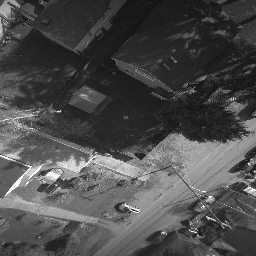

In [ ]:
cv2_imshow(train_images[0])

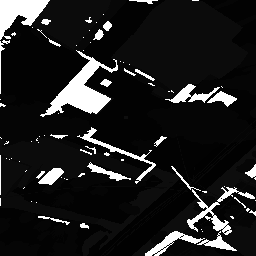

In [ ]:
cv2_imshow(train_masks[0])

In [ ]:
print(train_images[0])
print(train_masks[0])

[[61 61 82 ... 52 51 52]
 [55 99 62 ... 45 48 51]
 [94 66 67 ... 47 48 52]
 ...
 [80 45 58 ... 48 47 46]
 [52 47 70 ... 47 49 50]
 [63 61 64 ... 50 49 35]]
[[255 255 255 ...   2   2   2]
 [255 255 255 ...   2   2   2]
 [255 255 255 ...   2   2   2]
 ...
 [  5   5   5 ...  11  11  11]
 [  5   5   5 ...  11  11  11]
 [  5   5   5 ...  11  11  11]]


In [ ]:
#RUN THIS CODE COMPULSORY EVEN WITH BATCH TRAINING

In [ ]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K

In [ ]:
def IoU(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection

    IoU = (intersection + smooth) / (union + smooth)
    return IoU

In [ ]:

# model = models.att_unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512], n_labels=17,
#                            stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax',
#                            batch_norm=True, pool=False, unpool=False, weights='imagenet',
#                            freeze_backbone=True, freeze_batch_norm=True,
#                            name='attunet')

#

# model = models.u2net_2d((None, None, 3), n_labels=17,
#                         filter_num_down=[32, 64, 128],
#                         activation='ReLU', output_activation='Softmax',
#                         batch_norm=True, pool=True, unpool=False, deep_supervision=False, name='u2net')

# model = models.unet_plus_2d((None, None, 3), [64, 128, 256, 512], n_labels=17,
#                             stack_num_down=1, stack_num_up=1,
#                             activation='ReLU', output_activation='Softmax',

#                             batch_norm=True, pool=False, unpool=False, deep_supervision=True, name='xnet')

#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=IoU)

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose
from keras.models import Model

def encoder_block(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def decoder_block(inputs, skip_features, filters, kernel_size, strides):
    x = Conv2DTranspose(filters, kernel_size=(3,3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def LinkNet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    # Encoder
    enc1 = encoder_block(inputs, 32, 3, 1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder_block(pool1, 64, 3, 1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder_block(pool2, 128, 3, 1)
    # Decoder
    dec3 = decoder_block(enc3, enc2, 32, 3, 1)
    dec2 = decoder_block(dec3, enc1, 16, 3, 1)
    # Output
    outputs = Conv2D(num_classes, 1, activation='softmax')(dec2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (256, 256, 1)
num_classes = 17
model = LinkNet(input_shape, num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=IoU)


In [ ]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_13 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                          

In [ ]:
#TILL HERE

In [ ]:
X = train_images[:200]
Y = train_masks_cat[:200]
print(X.shape, Y.shape)

# Y = np.expand_dims(Y, axis=3)


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=12)

(200, 256, 256) (200, 256, 256, 17)


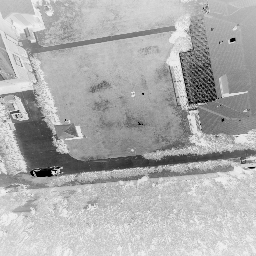

In [ ]:
cv2_imshow(x_val[20]*255)


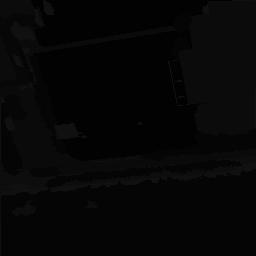

In [ ]:
cv2_imshow(np.argmax(y_val[20], axis=2))

In [ ]:
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=25,
   verbose=1,
   validation_data=(x_val, y_val)
)

Epoch 1/25
10/10 [==============================] - 9s 880ms/step - loss: 1.5263 - IoU: 0.2353 - val_loss: 2.7672 - val_IoU: 0.1622
Epoch 2/25
10/10 [==============================] - 8s 846ms/step - loss: 1.4932 - IoU: 0.2175 - val_loss: 3.4999 - val_IoU: 0.1859
Epoch 3/25
10/10 [==============================] - 8s 857ms/step - loss: 1.4388 - IoU: 0.2313 - val_loss: 3.3238 - val_IoU: 0.1273
Epoch 4/25
10/10 [==============================] - 8s 856ms/step - loss: 1.3614 - IoU: 0.2530 - val_loss: 6.7047 - val_IoU: 0.0621
Epoch 5/25
10/10 [==============================] - 9s 873ms/step - loss: 1.3535 - IoU: 0.2594 - val_loss: 3.3587 - val_IoU: 0.1351
Epoch 6/25
10/10 [==============================] - 9s 941ms/step - loss: 1.3209 - IoU: 0.2661 - val_loss: 2.2727 - val_IoU: 0.1718
Epoch 7/25
10/10 [==============================] - 9s 948ms/step - loss: 1.2929 - IoU: 0.2788 - val_loss: 1.9945 - val_IoU: 0.2226
Epoch 8/25
10/10 [==============================] - 9s 878ms/step - loss: 1.

In [ ]:
loss, val_loss, acc, val_acc = [], [], [], []

In [ ]:
#RUN THIS CELL AT THE END OF BATCH TRAINING, UNCOMMENT ALL IF NOT BATCH TRAINING

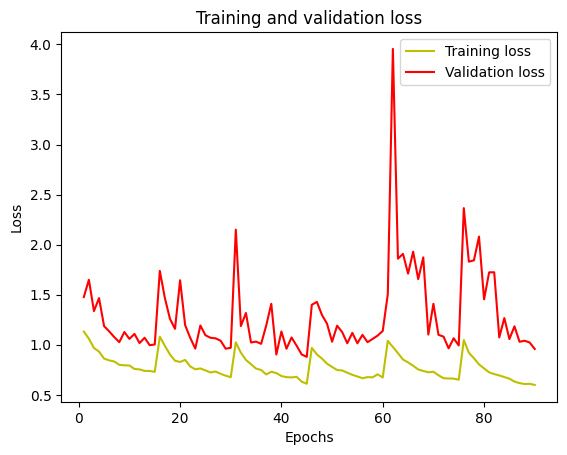

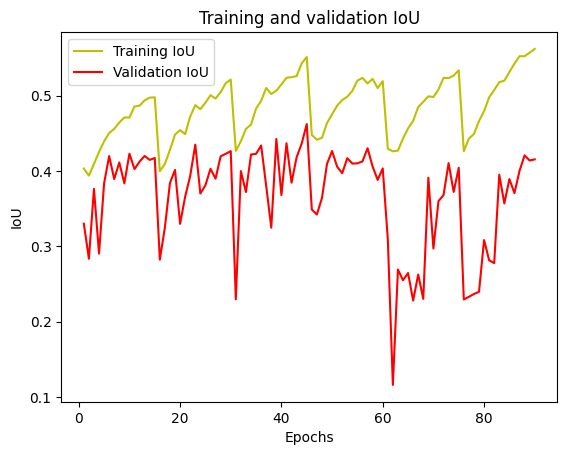

In [ ]:
# loss.extend(history.history['loss'])
# val_loss.extend(history.history['val_loss'])
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# acc.extend(history.history['IoU'])
# val_acc.extend(history.history['val_IoU'])

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(x_val)

2/2 [==============================] - 2s 12ms/step


In [ ]:
print(y_pred.shape)
y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape)

(40, 256, 256, 17)
(40, 256, 256)


0
1/1 [==============================] - 0s 38ms/step


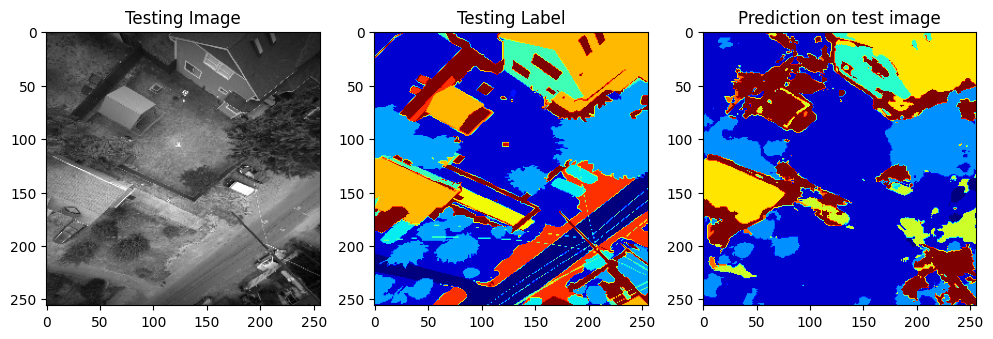

In [ ]:
import random
test_img_number = random.randint(0, len(x_val)-1)
# test_img_number = 9
print(test_img_number)
test_img = x_val[test_img_number]
ground_truth=y_val[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.argmax(ground_truth, axis = 2), cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
model.save("linknetv2.h5")

In [ ]:
model = keras.models.load_model("sUadd.h5", custom_objects={ 'IoU':IoU})

In [ ]:
train_images, train_masks = 0, 0

In [ ]:
#AUTO RUN CODE FOR MULTIPLE BATCH TESTING

In [ ]:
model

[  1   2   3   5   6   7  10  11  12  13  14 255]
Loading images for batch 0 completed
Training model for batch 0 started


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
10/10 [==============================] - 1s 126ms/step - loss: 1.1310 - IoU: 0.4032 - val_loss: 1.4764 - val_IoU: 0.3300
Epoch 2/15
10/10 [==============================] - 1s 133ms/step - loss: 1.0600 - IoU: 0.3938 - val_loss: 1.6488 - val_IoU: 0.2836
Epoch 3/15
10/10 [==============================] - 1s 134ms/step - loss: 0.9676 - IoU: 0.4092 - val_loss: 1.3361 - val_IoU: 0.3762
Epoch 4/15
10/10 [==============================] - 1s 133ms/step - loss: 0.9315 - IoU: 0.4251 - val_loss: 1.4657 - val_IoU: 0.2904
Epoch 5/15
10/10 [==============================] - 1s 129ms/step - loss: 0.8617 - IoU: 0.4391 - val_loss: 1.1858 - val_IoU: 0.3835
Epoch 6/15
10/10 [==============================] - 1s 124ms/step - loss: 0.8437 - IoU: 0.4503 - val_loss: 1.1336 - val_IoU: 0.4197
Epoch 7/15
10/10 [==============================] - 1s 134ms/step - loss: 0.8326 - IoU: 0.4557 - val_loss: 1.0768 - val_IoU: 0.3892
Epoch 8/15
10/10 [==============================] - 1s 131ms/step - loss: 0.

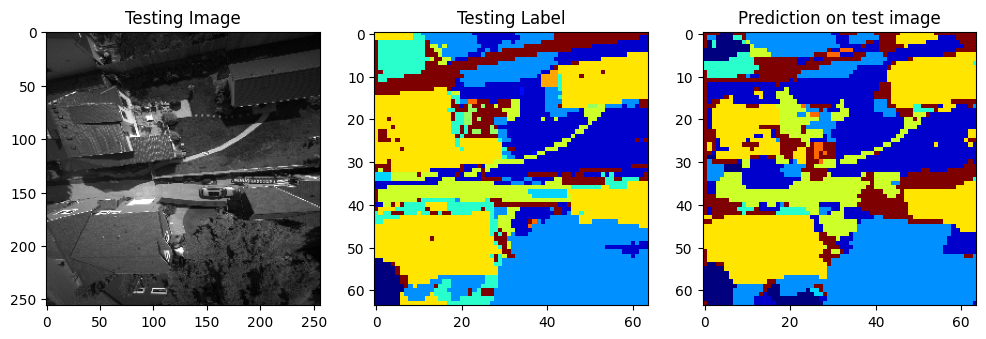

[  1   2   3   5   6   7   8   9  10  11  12  13  14 255]
Loading images for batch 1 completed
Training model for batch 1 started


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
10/10 [==============================] - 1s 131ms/step - loss: 1.0811 - IoU: 0.3996 - val_loss: 1.7377 - val_IoU: 0.2823
Epoch 2/15
10/10 [==============================] - 1s 131ms/step - loss: 0.9885 - IoU: 0.4093 - val_loss: 1.4663 - val_IoU: 0.3251
Epoch 3/15
10/10 [==============================] - 1s 134ms/step - loss: 0.9030 - IoU: 0.4279 - val_loss: 1.2589 - val_IoU: 0.3840
Epoch 4/15
10/10 [==============================] - 1s 134ms/step - loss: 0.8401 - IoU: 0.4482 - val_loss: 1.1590 - val_IoU: 0.4013
Epoch 5/15
10/10 [==============================] - 1s 125ms/step - loss: 0.8282 - IoU: 0.4541 - val_loss: 1.6437 - val_IoU: 0.3298
Epoch 6/15
10/10 [==============================] - 1s 126ms/step - loss: 0.8481 - IoU: 0.4488 - val_loss: 1.1946 - val_IoU: 0.3659
Epoch 7/15
10/10 [==============================] - 1s 125ms/step - loss: 0.7835 - IoU: 0.4721 - val_loss: 1.0695 - val_IoU: 0.3935
Epoch 8/15
10/10 [==============================] - 1s 125ms/step - loss: 0.

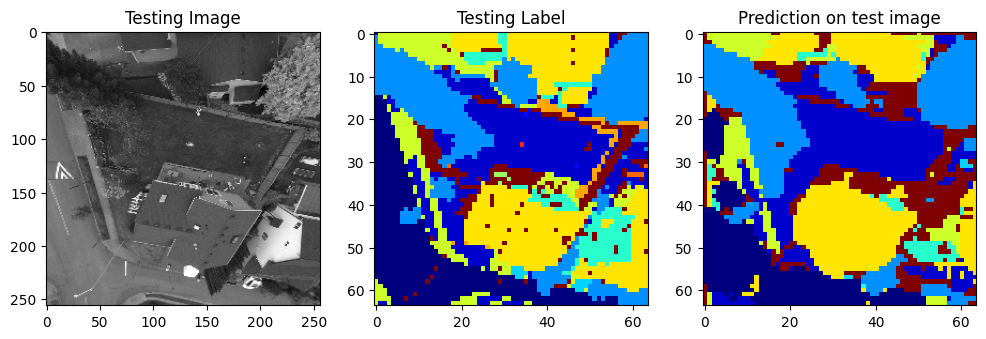

[  2   3   5   6   7  10  11  12  13  14 255]
Loading images for batch 2 completed
Training model for batch 2 started


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
10/10 [==============================] - 1s 131ms/step - loss: 1.0244 - IoU: 0.4265 - val_loss: 2.1492 - val_IoU: 0.2297
Epoch 2/15
10/10 [==============================] - 1s 130ms/step - loss: 0.9206 - IoU: 0.4394 - val_loss: 1.1862 - val_IoU: 0.3998
Epoch 3/15
10/10 [==============================] - 1s 123ms/step - loss: 0.8482 - IoU: 0.4557 - val_loss: 1.3171 - val_IoU: 0.3719
Epoch 4/15
10/10 [==============================] - 1s 131ms/step - loss: 0.8052 - IoU: 0.4613 - val_loss: 1.0228 - val_IoU: 0.4218
Epoch 5/15
10/10 [==============================] - 1s 124ms/step - loss: 0.7616 - IoU: 0.4827 - val_loss: 1.0309 - val_IoU: 0.4226
Epoch 6/15
10/10 [==============================] - 1s 124ms/step - loss: 0.7480 - IoU: 0.4930 - val_loss: 1.0090 - val_IoU: 0.4337
Epoch 7/15
10/10 [==============================] - 1s 123ms/step - loss: 0.7035 - IoU: 0.5100 - val_loss: 1.1918 - val_IoU: 0.3799
Epoch 8/15
10/10 [==============================] - 1s 124ms/step - loss: 0.

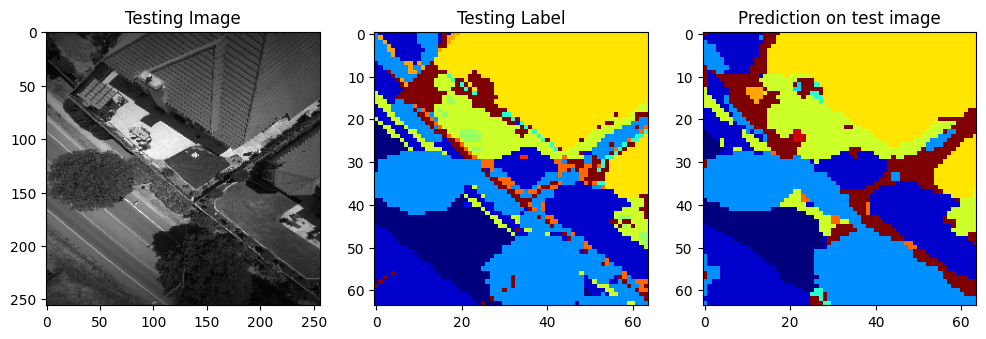

[  1   2   3   5   6   7   9  10  11  14 255]
Loading images for batch 3 completed
Training model for batch 3 started


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
10/10 [==============================] - 1s 127ms/step - loss: 0.9689 - IoU: 0.4477 - val_loss: 1.3991 - val_IoU: 0.3488
Epoch 2/15
10/10 [==============================] - 1s 124ms/step - loss: 0.9036 - IoU: 0.4414 - val_loss: 1.4281 - val_IoU: 0.3422
Epoch 3/15
10/10 [==============================] - 1s 130ms/step - loss: 0.8617 - IoU: 0.4440 - val_loss: 1.2977 - val_IoU: 0.3640
Epoch 4/15
10/10 [==============================] - 1s 132ms/step - loss: 0.8110 - IoU: 0.4634 - val_loss: 1.2102 - val_IoU: 0.4094
Epoch 5/15
10/10 [==============================] - 1s 124ms/step - loss: 0.7782 - IoU: 0.4752 - val_loss: 1.0304 - val_IoU: 0.4264
Epoch 6/15
10/10 [==============================] - 1s 126ms/step - loss: 0.7474 - IoU: 0.4865 - val_loss: 1.1901 - val_IoU: 0.4056
Epoch 7/15
10/10 [==============================] - 1s 135ms/step - loss: 0.7428 - IoU: 0.4940 - val_loss: 1.1256 - val_IoU: 0.3970
Epoch 8/15
10/10 [==============================] - 1s 132ms/step - loss: 0.

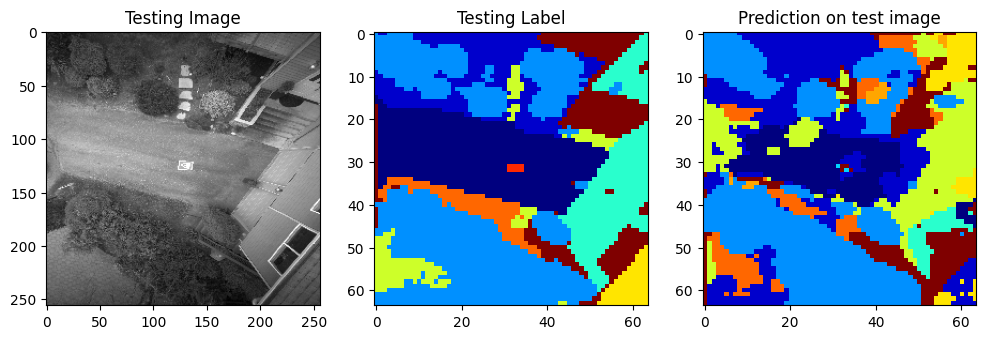

[  2   3   5   7   9  10  11  12  13  14 255]
Loading images for batch 4 completed
Training model for batch 4 started


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
10/10 [==============================] - 1s 132ms/step - loss: 1.0390 - IoU: 0.4292 - val_loss: 1.5061 - val_IoU: 0.3095
Epoch 2/15
10/10 [==============================] - 1s 130ms/step - loss: 0.9772 - IoU: 0.4260 - val_loss: 3.9547 - val_IoU: 0.1162
Epoch 3/15
10/10 [==============================] - 1s 136ms/step - loss: 0.9163 - IoU: 0.4269 - val_loss: 1.8596 - val_IoU: 0.2692
Epoch 4/15
10/10 [==============================] - 1s 134ms/step - loss: 0.8524 - IoU: 0.4430 - val_loss: 1.9076 - val_IoU: 0.2551
Epoch 5/15
10/10 [==============================] - 1s 126ms/step - loss: 0.8233 - IoU: 0.4564 - val_loss: 1.7102 - val_IoU: 0.2646
Epoch 6/15
10/10 [==============================] - 1s 125ms/step - loss: 0.7903 - IoU: 0.4664 - val_loss: 1.9295 - val_IoU: 0.2281
Epoch 7/15
10/10 [==============================] - 1s 126ms/step - loss: 0.7529 - IoU: 0.4847 - val_loss: 1.6552 - val_IoU: 0.2626
Epoch 8/15
10/10 [==============================] - 1s 132ms/step - loss: 0.

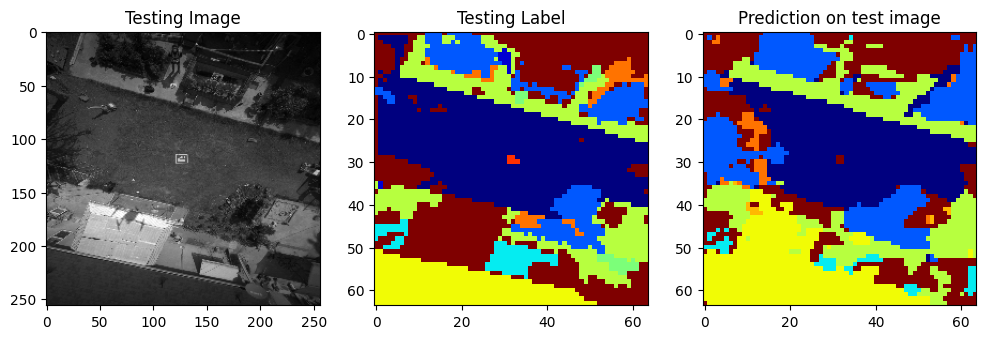

[  2   3   5   7   9  10  11  12  13  14 255]
Loading images for batch 5 completed
Training model for batch 5 started


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/15
10/10 [==============================] - 1s 135ms/step - loss: 1.0468 - IoU: 0.4262 - val_loss: 2.3646 - val_IoU: 0.2296
Epoch 2/15
10/10 [==============================] - 1s 125ms/step - loss: 0.9202 - IoU: 0.4427 - val_loss: 1.8296 - val_IoU: 0.2330
Epoch 3/15
10/10 [==============================] - 1s 125ms/step - loss: 0.8650 - IoU: 0.4489 - val_loss: 1.8433 - val_IoU: 0.2368
Epoch 4/15
10/10 [==============================] - 1s 126ms/step - loss: 0.8036 - IoU: 0.4661 - val_loss: 2.0802 - val_IoU: 0.2397
Epoch 5/15
10/10 [==============================] - 1s 132ms/step - loss: 0.7631 - IoU: 0.4793 - val_loss: 1.4534 - val_IoU: 0.3084
Epoch 6/15
10/10 [==============================] - 1s 134ms/step - loss: 0.7245 - IoU: 0.4976 - val_loss: 1.7232 - val_IoU: 0.2815
Epoch 7/15
10/10 [==============================] - 1s 134ms/step - loss: 0.7067 - IoU: 0.5073 - val_loss: 1.7238 - val_IoU: 0.2778
Epoch 8/15
10/10 [==============================] - 1s 124ms/step - loss: 0.

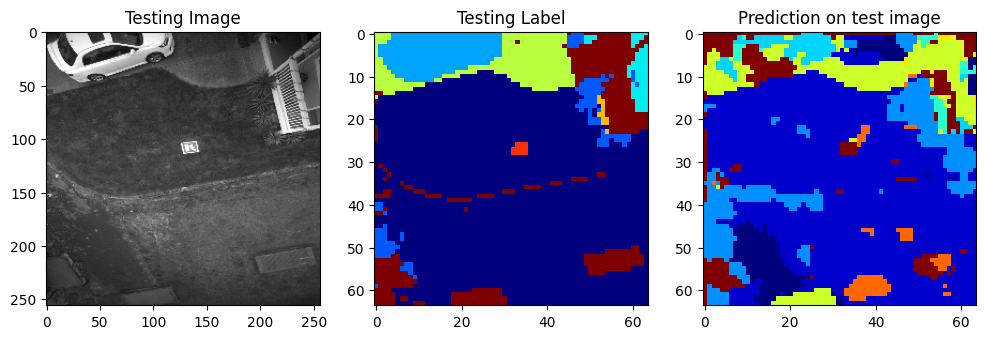

In [ ]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
loss, val_loss, acc, val_acc = [], [], [], []
SIZE_Y = 256
batch_start = 0
batch_end = 1200
batch_size = 200
for batch in range(batch_start, batch_end, batch_size):
  train_images,  train_masks =  load_images(batch, batch+batch_size)
  print(f"Loading images for batch {(batch-batch_start)//batch_size} completed")

  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  n, h, w = train_masks.shape
  reshaped = train_masks.reshape(-1, 1)
  reshaped_encode = le.fit_transform(reshaped)
  encoded = reshaped_encode.reshape(n, h, w)

  n_classes = len(np.unique(encoded))
  encoded = np.expand_dims(encoded, axis=3)

  from keras.utils import to_categorical
  train_masks_cat = to_categorical(encoded, num_classes = n_classes)
  train_masks_cat = train_masks_cat.reshape(n, h, w, n_classes)

  X = train_images[:200]
  Y = train_masks_cat[:200]

  from sklearn.model_selection import train_test_split
  x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=12)

  print(f"Training model for batch {(batch-batch_start)//batch_size} started")
  history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=15,
   verbose=1,
   validation_data=(x_val, y_val)
  )

  print(f"Training model for batch {(batch-batch_start)//batch_size} completed")

  acc.extend(history.history['IoU'])
  val_acc.extend(history.history['val_IoU'])
  loss.extend(history.history['loss'])
  val_loss.extend(history.history['val_loss'])

  import random
  # test_img_number = random.randint(0, len(x_val)-1)
  test_img_number = 18
  print(f"Test image number: {test_img_number}, Batch number: {(batch-batch_start)//batch_size}")
  test_img = x_val[test_img_number]
  ground_truth=y_val[test_img_number]
  # test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]

  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img, cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(np.argmax(ground_truth, axis = 2), cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='jet')
  plt.show()